In [ ]:
%pip install pydot
%pip install cupy-cuda11x
%pip install pm4py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.4/95.4 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26096 sha256=dedc4287b0c0a4cbc2c140c85a9dbfe4e1e4d7449acd692818d8105caeba676e
  Stored in directory: /root/.cache/pip/wheels/fa/80/8c/43488a924a046b733b64de3fac99252674c892a4c3801c0a61
Successfully built intervaltree


In [ ]:
from google.colab import files

from google.colab import drive


directory = '/content/problems'

# Clean dir
!rm {directory}/*

# Clean files
!rm *

# Upload .dot files
print("Please Upload the dot formatted declare file")
uploaded = files.upload()

for file_name in uploaded.keys():
    print(f'Uploaded file: {file_name}')

# Mount Google Drive to get the log file (large size)
drive.mount('/content/drive')


rm: cannot remove '/content/problems/*': No such file or directory
rm: cannot remove 'sample_data': Is a directory
Please Upload the dot formatted declare file


Saving declare1.dot to declare1.dot
Uploaded file: declare1.dot
Mounted at /content/drive


In [ ]:
import pydot
import random
from datetime import datetime, timedelta
import os
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.log.exporter.xes import exporter as xes_exporter

# let the user define this section
xes_file = "path_to_the_xes_log_file.xes"
# one lifecycle for each activity in the trace
dot_files = ["path_to_the_dot_declare_file_1.dot","path_to_the_dot_declare_file_2.dot","path_to_the_dot_declare_file_3.dot"]
domain_name = "your_domain_name"
problem_limit = 4 # if you want to parse problems until a bound is reached
problem_automata = 1 # number of automata for the dot files if more than one
problem_automata_list = [1] # if you want to sample traces
problem_automata_debug_list = [0] # if you want to debug traces in this list
problem_automata_noise_list = [1] # if you want to sample the traces where to inject noise
activities = ["Handle Case", "Call Outbound", "Inbound Call", "Handle Email", "Inbound Email"] # let the user define its own activities
lifecycles = ["assign","start","complete"] # let the user define its own lifecycles
lifecycle_states = ["init_state","assigned_state","started_state","completed_state","sink_state"]
resources = ["Susi", "John", "Eric"] # let the user define its own resources
max_amount = 2 # upper bound of elements to add and delete if we add noise probabilistically
# log traces tags
trace_id_tag = "concept:name"
event_id_tag = "concept:name"
activity_tag = "Activity"
lifecycle_tag = "lifecycle:transition"
org_tag = "org:resource"
resource_tag = "Resource"
timestamp_tag = "time:timestamp"
# list of moves
move_1 = "swap"
move_2 = "delete"
move_3 = "add"
move_4 = "modify"
move_5 = "pass"
# list of weights for each move
move_1_w = 0.1
move_2_w = 0.1
move_3_w = 0.4
move_4_w = 0.2
move_5_w = 0.2
# list of amount of move for each choice
amount_move_1 = amount_move_2 = amount_move_3 = amount_move_4 = 2 # let the user define them


def write_pddl_problem(output_file, problem_name, initial_state, objects, goal_state):
    """
    Function to write the pddl problem with content settled by parameters in input.

    Parameters:
        output_file (file name) : The output file name.
        problem_name (file name): The pddl problem name.
        initial_state (list): The lines representing the initial state of the pddl problem.
        objects (dict): A dictionary representing the objects of the pddl problem.
        goal_state (list): The lines representing the goal state of the pddl problem.

    """
    directory = 'path_to_the_problems_directory'

    file_path = os.path.join(directory, output_file)

    if not os.path.exists(directory):
        os.makedirs(directory)

    with open(file_path, 'w') as f:
        f.write(f"(define (problem {problem_name})\n")
        f.write(f"\t(:domain {domain_name})\n\n")

        # Objects section
        f.write("\t(:objects\n")
        for obj_type, obj_list in objects.items():
            f.write(f"\t\t{' '.join(obj_list)} - {obj_type}\n")
        f.write("\t)\n\n")

        # Initial state section
        f.write("\t(:init\n")
        for predicate in initial_state:
            f.write(f"\t\t{predicate}\n")
        f.write("\t)\n\n")

        # Goal state section
        f.write("\t(:goal\n")
        f.write(f"\t\t(and\n")
        for predicate in goal_state:
            f.write(f"\t\t\t{predicate}\n")
        f.write("\t\t)\n")
        f.write("\t)\n")
        f.write("\t(:metric minimize (total-cost))\n")
        f.write(")\n")
    print("Writed file : ",file_path)

def generate_formula(initial_state,objects,goal_state,found_activities):

   for automaton_index in range(0,problem_automata):
      # Parse the .dot file and extract graph structure
      graph = pydot.graph_from_dot_file(dot_files[automaton_index])[0]
      if automaton_index == 0:
        # Iterate over each automaton
        automaton = {"states": [], "transitions": []}

        # Extract states and transitions from graph
        for node in graph.get_nodes():
            state_name = node.get_name().strip('"')
            state_shape = node.get_shape().strip('"')
            if state_name:
              if state_name != "initial":
                automaton["states"].append(f"s{state_name}")
                if state_shape == "doublecircle":
                  initial_state.append(f"(final_state s{state_name})")
                  goal_state.append(f"(cur_state s{state_name})")



        for edge in graph.get_edges():
            source = edge.get_source().strip('"')
            target = edge.get_destination().strip('"')
            original_labels_string = edge.get_label()
            original_label= edge.get_label()
            label = edge.get_label()  # Get the label of the edge (arc)
            if label != None :
              label = label.replace('"','')
              if label.find(f"_{lifecycles[0]}") != -1 :
                label = label.replace(f"_{lifecycles[0]}","")
              elif label.find(f"_{lifecycles[1]}") != -1 :
                label = label.replace(f"_{lifecycles[1]}","")
              elif label.find(f"_{lifecycles[2]}") != -1:
                label = label.replace(f"_{lifecycles[2]}","")
              if label.find('\\n') != -1 :
                original_labels_string = original_labels_string.replace('"','')
                original_labels_string_array = original_labels_string.split('\\n')
                labels = label.split('\\n')
                length = len(labels)
                activities = []
                for i in range(0,length):
                  activities.append(labels[i])
                for act in activities :
                  if act not in found_activities :
                    initial_state.append(f"(cur_lifecycle_state {act} {lifecycle_states[0]})")
                    initial_state.append(f"(final_lifecycle_state {act} {lifecycle_states[3]})")
                    initial_state.append(f"(lifecycle_activity_of {act} {act}_{lifecycles[0]})")
                    initial_state.append(f"(lifecycle_activity_of {act} {act}_{lifecycles[1]})")
                    initial_state.append(f"(lifecycle_activity_of {act} {act}_{lifecycles[2]})")
                    initial_state.append(f"(lifecycle {lifecycle_states[0]} {act}_{lifecycles[0]} {lifecycle_states[1]})")
                    #initial_state.append(f"(lifecycle {lifecycle_states[0]} {act}_{lifecycles[1]} {lifecycle_states[4]})")
                    #initial_state.append(f"(lifecycle {lifecycle_states[0]} {act}_{lifecycles[2]} {lifecycle_states[4]})")
                    initial_state.append(f"(lifecycle {lifecycle_states[1]} {act}_{lifecycles[1]} {lifecycle_states[2]})")
                    #initial_state.append(f"(lifecycle {lifecycle_states[1]} {act}_{lifecycles[0]} {lifecycle_states[4]})")
                    #initial_state.append(f"(lifecycle {lifecycle_states[1]} {act}_{lifecycles[2]} {lifecycle_states[4]})")
                    initial_state.append(f"(lifecycle {lifecycle_states[2]} {act}_{lifecycles[2]} {lifecycle_states[3]})")
                    #initial_state.append(f"(lifecycle {lifecycle_states[2]} {act}_{lifecycles[0]} {lifecycle_states[4]})")
                    #initial_state.append(f"(lifecycle {lifecycle_states[2]} {act}_{lifecycles[1]} {lifecycle_states[4]})")
                    initial_state.append(f"(lifecycle {lifecycle_states[3]} {act}_{lifecycles[0]} {lifecycle_states[0]})")
                    #initial_state.append(f"(lifecycle {lifecycle_states[3]} {act}_{lifecycles[1]} {lifecycle_states[4]})")
                    #initial_state.append(f"(lifecycle {lifecycle_states[3]} {act}_{lifecycles[2]} {lifecycle_states[4]})")
                    goal_state.append(f"(cur_lifecycle_state {act} {lifecycle_states[3]})")
                    objects["activity"].append(act)
                    objects["lifecycle_activity"].append(f"{act}_{lifecycles[0]}")
                    objects["lifecycle_activity"].append(f"{act}_{lifecycles[1]}")
                    objects["lifecycle_activity"].append(f"{act}_{lifecycles[2]}")
                    found_activities.append(act)
                for act_name in original_labels_string_array :
                  if source and target and act_name:
                    if source != target :
                      if source != "initial" :
                        automaton["transitions"].append((source, target, act_name))
                      else:
                        initial_state.append(f"(cur_state s{target})")
              else :
                activity = label
                if activity not in found_activities :
                  initial_state.append(f"(cur_lifecycle_state {activity} {lifecycle_states[0]})")
                  initial_state.append(f"(final_lifecycle_state {activity} {lifecycle_states[3]})")
                  initial_state.append(f"(lifecycle_activity_of {activity} {activity}_{lifecycles[0]})")
                  initial_state.append(f"(lifecycle_activity_of {activity} {activity}_{lifecycles[1]})")
                  initial_state.append(f"(lifecycle_activity_of {activity} {activity}_{lifecycles[2]})")
                  initial_state.append(f"(lifecycle {lifecycle_states[0]} {activity}_{lifecycles[0]} {lifecycle_states[1]})")
                  #initial_state.append(f"(lifecycle {lifecycle_states[0]} {activity}_{lifecycles[1]} {lifecycle_states[4]})")
                  #initial_state.append(f"(lifecycle {lifecycle_states[0]} {activity}_{lifecycles[2]} {lifecycle_states[4]})")
                  initial_state.append(f"(lifecycle {lifecycle_states[1]} {activity}_{lifecycles[1]} {lifecycle_states[2]})")
                 # initial_state.append(f"(lifecycle {lifecycle_states[1]} {activity}_{lifecycles[0]} {lifecycle_states[4]})")
                 # initial_state.append(f"(lifecycle {lifecycle_states[1]} {activity}_{lifecycles[2]} {lifecycle_states[4]})")
                  initial_state.append(f"(lifecycle {lifecycle_states[2]} {activity}_{lifecycles[2]} {lifecycle_states[3]})")
                  #initial_state.append(f"(lifecycle {lifecycle_states[2]} {activity}_{lifecycles[0]} {lifecycle_states[4]})")
                  #initial_state.append(f"(lifecycle {lifecycle_states[2]} {activity}_{lifecycles[1]} {lifecycle_states[4]})")
                  initial_state.append(f"(lifecycle {lifecycle_states[3]} {activity}_{lifecycles[0]} {lifecycle_states[0]})")
                  #initial_state.append(f"(lifecycle {lifecycle_states[3]} {activity}_{lifecycles[1]} {lifecycle_states[4]})")
                  #initial_state.append(f"(lifecycle {lifecycle_states[3]} {activity}_{lifecycles[2]} {lifecycle_states[4]})")
                  goal_state.append(f"(cur_lifecycle_state {activity} {lifecycle_states[3]})")
                  objects["activity"].append(activity)
                  objects["lifecycle_activity"].append(f"{activity}_{lifecycles[0]}")
                  objects["lifecycle_activity"].append(f"{activity}_{lifecycles[1]}")
                  objects["lifecycle_activity"].append(f"{activity}_{lifecycles[2]}")
                  found_activities.append(activity)
                if source and target and original_label:
                 if source != target :
                   if source != "initial" :
                     automaton["transitions"].append((source, target, original_label))
                   else:
                     initial_state.append(f"(cur_state s{target})")


        # Extract from declare model to formula automata
        start = True
        for state in automaton["states"]:
          if start == True :
            initial_state.append(f"(cur_state {state})")
            start = False
          objects["automaton_state"].append(state)
        for source, target, label in automaton["transitions"]:
            label = label.replace('"','')
            initial_state.append(f"(automaton s{source} {label} s{target})")

def inject_noise_move_1(noisy_trace, noisy_event, noisy_index, prob = False, chose_amount = 1):
    """
    Function to inject noise amount for move_1: swap choice.
    Swap two events in a trace chose_amount elements far apart.

    Parameters:
        noisy_trace (pm4py.Trace) : The original log trace.
        noisy_event (pm4py.Event): The original log trace event.
        noisy_index (integer): The original log trace event index.
        prob (default = False) (bool): Flag to decide whether to injects noise in a probabilistic way.
        chose_amount (default = 1) (integer): To decide the amount of the move for each choice.

    """
    if prob:
      # init amount
      start_index = 1
      end_index = len(noisy_trace)
      # amount : Another source of randomness that depends on the specific function
      amount = random.randint(start_index, end_index)
    else:
      amount = chose_amount

    # get the indexes of the events
    event_index_1 = noisy_index
    event_index_2 = (event_index_1 + amount) % len(noisy_trace)
    # get the events
    event_1 = noisy_event
    event_2 = noisy_trace[event_index_2]

    # swap the events
    noisy_trace[event_index_1] = event_2
    noisy_trace[event_index_2] = event_1

def inject_noise_move_2(noisy_trace, noisy_trace_index, trace_events_to_delete, noisy_event, noisy_index, prob = False, chose_amount = 1):
    """
    Function to inject noise amount for move_2: delete choice.
    Delete chose_amount events in a trace.

    Parameters:
        noisy_trace (pm4py.Trace) : The original log trace.
        noisy_trace_index (integer): The original log trace index.
        traces_events_to_delete (list): List to keep track of events deleted.
        noisy_event (pm4py.Event): The original log trace event.
        noisy_index (integer): The original log trace event index.
        prob (default = False) (bool): Flag to decide whether to injects noise in a probabilistic way.
        chose_amount (default = 1) (integer): To decide the amount of the move for each choice.

    """
    if prob:
      # init amount
      start_index = 0
      end_index = 1
      # amount : Another source of randomness that depends on the specific function.
      amount = random.randint(start_index, end_index)
    else:
      amount = chose_amount
    # delete
    if amount == 1 or amount == 2 :
      trace_events_to_delete[noisy_trace_index].append(noisy_event)



def inject_noise_move_3(noisy_trace, noisy_trace_index, noisy_event, noisy_index, trace_events_to_skip, prob = False, chose_amount = 1):
    """
    Function to inject noise amount for move_3: add choice.
    Add chose_amount events in a trace.
    Parameters:
        noisy_trace (pm4py.Trace) : The original log trace.
        noisy_event (pm4py.Event): The original log trace event.
        noisy_index (integer): The original log trace event index.
        prob (default = False) (bool): Flag to decide whether to injects noise in a probabilistic way.
        chose_amount (default = 1) (integer): To decide the amount of the move for each choice.

    """
    if prob:
      # init amount
      start_index = 1
      end_index = max_amount
      # amount : Another source of randomness that depends on the specific function.
      amount = random.randint(start_index, end_index)
    else:
      amount = chose_amount

    for _ in range(amount):
      # sample parameters
      activity = random.choices(activities, k = 1)[0]
      lifecycle = random.choices(lifecycles, k = 1)[0]
      resource = random.choices(resources, k = 1)[0]
      start_date = datetime(2022, 3, 1, 0, 0, 0)  # March 1, 2022
      end_date = datetime(2023, 7, 31, 23, 59, 59)  # July 31, 2023

      # random timedelta within the range
      random_timedelta = random.randint(0, int((end_date - start_date).total_seconds()))

      # random timedelta to the start date to get a random timestamp
      random_timestamp = start_date + timedelta(seconds = random_timedelta)


      # Create a new event dictionary representing the event you want to add
      new_event = {event_id_tag: activity,
              lifecycle_tag: lifecycle,
              org_tag: resource,
              timestamp_tag: random_timestamp,
                  #datetime.strptime("2010-03-04T11:46:00.000+01:00", "%Y-%m-%dT%H:%M:%S.%f%z"),
              activity_tag: activity,
              resource_tag: resource}

      # Add the new event to the current trace
      #noisy_trace.append(new_event)
      noisy_trace.insert(noisy_index + 1 , new_event) # insert
      trace_events_to_skip[noisy_trace_index].append(new_event)

def inject_noise_move_4(noisy_trace, noisy_event, prob = False, chose_amount = 1):
    """
    Function to inject noise amount for move_4: modify choice.
    Modify chose_amount events in a trace.

    Parameters:
        noisy_trace (pm4py.Trace) : The original log trace.
        noisy_event (pm4py.Event): The original log trace event.
        prob (default = False) (bool): Flag to decide whether to injects noise in a probabilistic way.
        chose_amount (default = 1) (integer): To decide the amount of the move for each choice.

    """
    if prob :
      # init amount
      start_index = 1
      end_index = 5
      # amount : Another source of randomness that depends on the specific function.
      amount = random.randint(start_index, end_index)
    else :
      amount = chose_amount

    if amount >= 1 :
      # modify current activity
      activity = random.choices(activities, k = 1)[0]
      noisy_event[event_id_tag] = activity
      noisy_event[activity_tag] = activity
    if amount >= 2 :
      # modify current lifecycle
      lifecycle = random.choices(lifecycles, k = 1)[0]
      noisy_event[lifecycle_tag] = lifecycle
    if amount >= 3 :
      # modify current resource
      resource = random.choices(resources, k = 1)[0]
      noisy_event[org_tag] = resource
      noisy_event[resource_tag] = resource
    if amount >= 4 :
      # modify current timestamp
      start_date = datetime(2022, 3, 1, 0, 0, 0)  # March 1, 2022
      end_date = datetime(2023, 7, 31, 23, 59, 59)  # July 31, 2023

      # random timedelta within the range
      random_timedelta = random.randint(0, int((end_date - start_date).total_seconds()))

      # random timedelta to the start date to get a random timestamp
      random_timestamp = start_date + timedelta(seconds = random_timedelta)
      noisy_event[timestamp_tag] = random_timestamp




def inject_noise(xes_file, trace_events_to_delete, prob = False, chose_amount = 1):
    """
    Function to preprocess the xes log and inject noise for each trace.
    The injection is made by several parameters.
    The function choose the move element with probability/percentage given by {move}_w param.
    The possible default moves are :
      1) swap --> swap two events in the trace
      2) delete --> delete an event in the trace
      3) add --> add an event in the trace
      4) modify --> modify an event in the trace
      5) pass --> this moves does not modify the trace

    Other moves can be added.
    Each move choice is made up by a chose_amount amount if acting deterministically otherwise the amount
    for the move is randomly selected.

    Parameters:
        xes_file (file name): A xes formatted log file path name.
        traces_events_to_delete (list): List to keep track of events deleted.
        prob (default = False) (bool): Flag to decide whether to injects noise in a probabilistic way.
        chose_amount (default = 1) (integer): To decide the amount of the move for each choice.

    Returns:
        noisy_log (pm4py.Log): A new log with the noise injected.
    """

    # store the events added because of noise to the trace to avoid long processing
    trace_events_to_skip = {}


    if not prob :
      sum_weights = move_1_w + move_2_w + move_3_w + move_4_w + move_5_w
      sum_rounded = round(sum_weights, 10)  # Round to 10 decimal places
      result = (sum_rounded == 1)
      assert(result == True)

    # list of choices for the rand moves
    moves = [move_1,move_2,move_3,move_4,move_5]

    # list containing weights,
    # in functions like this weights are interpreted as relative probabilities so they don't need to sum to 1
    weights = [move_1_w, move_2_w, move_3_w, move_4_w, move_5_w]

    # import log
    noisy_log = xes_importer.apply(xes_file)
    num = 0
    # loop for all traces in the log
    for noisy_trace_index, noisy_trace in enumerate(noisy_log):

      trace_events_to_delete[noisy_trace_index] = []
      trace_events_to_skip[noisy_trace_index] = []
      # inject noise
      if not prob:
        noisy_trace_length = len(noisy_trace)
        curr_moves = [move_1,move_2,move_3,move_4,move_5]
        total_weight = round(sum(weights),10)
        amounts = [0] * len(weights)

        # remaining trace length to distribute
        remaining_trace_length = noisy_trace_length

        # scaling each weight to make the sum equal to noisy_trace_length
        for k in range(len(weights)):
            # Calculate the scaled value using integer division
            scaled_value = int((weights[k] * noisy_trace_length) // total_weight)

            # Assign the scaled value to amounts
            amounts[k] = scaled_value

            # Update the remaining trace length
            remaining_trace_length -= scaled_value

        # distributing the remaining trace length evenly across the amounts
        for k in range(remaining_trace_length):
            amounts[k] += 1
      else:
        amounts = []


      num = num + 1
      if num in problem_automata_noise_list :

        # clean structures
        print("New trace: ",noisy_trace.attributes[trace_id_tag],"Trace Length: ",len(noisy_trace),"Amounts: ",amounts)
        noisy_trace_id = noisy_trace.attributes[trace_id_tag].replace(" ", "_")
        cur_activity = "init"

        for noisy_index, noisy_event in enumerate(noisy_trace):
          if (noisy_event not in trace_events_to_delete[noisy_trace_index]) and (noisy_event not in trace_events_to_skip[noisy_trace_index]) :
            if cur_activity != noisy_event[activity_tag].replace(" ","_") :
              # new activity found
              #print("Old activity: ",cur_activity,", New activity: ",noisy_event[activity_tag].replace(" ","_"))
              cur_activity = noisy_event[activity_tag].replace(" ","_")

            if prob:
              # Perform a random choice biased with weights
              biased_choice = random.choices(moves, weights=weights, k=1)[0]
            else:
              move_to_remove = ""

              # Iterate over the list in reverse order to avoid index changes
              for k in range(len(amounts)):
                  if amounts[k] == 0:
                    move_to_remove = moves[k]

              # Remove elements from the list after the loop
              if move_to_remove in curr_moves :
                curr_moves.remove(move_to_remove)
              if len(curr_moves) < 1 :
                print("Trace completed, go to the next trace",noisy_event)
                break

              biased_choice = random.choice(curr_moves)

            # logging the choice
            if biased_choice == move_1:
                print("You chose case 1 SWAP")
                # inject noise amount
                if not prob:
                  amounts[0] = amounts[0] - 1
                  inject_noise_move_1(noisy_trace=noisy_trace,  noisy_event=noisy_event, noisy_index=noisy_index, chose_amount=amount_move_1)
                else:
                  inject_noise_move_1(noisy_trace=noisy_trace, noisy_event=noisy_event, noisy_index=noisy_index, prob=prob)
            elif biased_choice == move_2:
                print("You chose case 2 DELETE")
                # inject noise amount
                if not prob:
                  amounts[1] = amounts[1] - 1
                  inject_noise_move_2(noisy_trace=noisy_trace, noisy_trace_index=noisy_trace_index, trace_events_to_delete=trace_events_to_delete, noisy_event=noisy_event, noisy_index=noisy_index, chose_amount=amount_move_2)
                else:
                  inject_noise_move_2(noisy_trace=noisy_trace, noisy_trace_index=noisy_trace_index, trace_events_to_delete=trace_events_to_delete, noisy_event=noisy_event, noisy_index=noisy_index, prob = prob)
            elif biased_choice == move_3:
                print("You chose case 3 ADD")
                # inject noise amount
                if not prob:
                  amounts[2] = amounts[2] - 1
                  inject_noise_move_3(noisy_trace=noisy_trace, noisy_trace_index=noisy_trace_index, noisy_event=noisy_event, noisy_index=noisy_index, trace_events_to_skip=trace_events_to_skip, chose_amount=amount_move_3)
                else:
                  inject_noise_move_3(noisy_trace=noisy_trace, noisy_trace_index=noisy_trace_index, noisy_event=noisy_event, noisy_index=noisy_index, trace_events_to_skip=trace_events_to_skip, prob=prob)
            elif biased_choice == move_4:
                print("You chose case 4 MODIFY")
                # inject noise amount
                if not prob:
                  amounts[3] = amounts[3] - 1
                  inject_noise_move_4(noisy_trace=noisy_trace, noisy_event=noisy_event, chose_amount=amount_move_4)
                else:
                  inject_noise_move_4(noisy_trace=noisy_trace, noisy_event=noisy_event, prob=prob)
            elif biased_choice == move_5:
                print("You chose case 5 PASS")
                if not prob:
                  amounts[4] = amounts[4] - 1
            else:
                print("Error: Invalid case", biased_choice)
                return None

    return noisy_log

def debug_function(log):
    """
    Function to cat the log given as parameter only for the indexes in problem_automata_list

    Parameters:
        log (pm4py.Log): A log imported.oice.
    """
    debug_log = [log[i] for i in problem_automata_debug_list]
    for debug_trace in debug_log:
      print("Number of events:", len(debug_trace),"\n")
      print("<Trace Start> --------------------------------------------\n")
      print("\t<Trace ID>:", debug_trace.attributes[trace_id_tag],"\n")
      for debug_event in debug_trace:
          print("<Event Start> --------------------------------------------\n")
          print("\t<Event>:", debug_event[event_id_tag],"\n")
          print("\t\t<Lifecycle>:", debug_event[lifecycle_tag],"\n")
          print("\t\t<Timestamp>:", debug_event[timestamp_tag],"\n")
          print("\t\t<Activity>:", debug_event[activity_tag],"\n")
          print("\t\t<Resource>:", debug_event[resource_tag],"\n")
          print("<Event End> --------------------------------------------\n")
      print("<Trace End> --------------------------------------------\n")

def generate(noise = False, debug = False, prob = False, chose_amount = 1):
    """
    Main Function to generate pddl problems from:
    1) The xes formatted log imported with pm4py.
    2) The dot formatted declare model.

    The function can inject noise in the traces and can cat the log traces.

    Parameters:
        noise (bool): A flag to decide wheter to add noise to the traces.
        debug (bool): A flag to decide wheter to debug the traces.
        prob (default = False) (bool): Flag to decide whether to injects noise in a probabilistic way.
        chose_amount (default = 1) (integer): To decide the amount of the move for each choice.

    Returns:
        A string stating the result of the generation or None if something went wrong during the process.
    """

    # init dict of element to skip for each trace
    traces_events_to_delete = {}
    # Parse the XES log and check if the noise must be injected
    if noise == False :
      log = xes_importer.apply(xes_file)
      if debug:
        debug_function(log)
        return "Debug"
    else :
      log = inject_noise(xes_file=xes_file, trace_events_to_delete=traces_events_to_delete, prob=prob, chose_amount=chose_amount)
      # export the noisy log to XES format
      xes_exporter.apply(log, "noisy_log.xes")
      if log is None:
        return log
      if debug:
        debug_function(log)
        return "Debug"


    num = 0
    # Extract activities and lifecycle from xes to lifecycle and trace automata
    for trace_index, trace in enumerate(log):
      num = num + 1
      if num in problem_automata_list :
        # clean structures
        print("New trace",trace.attributes[trace_id_tag])
        trace_id = trace.attributes[trace_id_tag].replace(" ", "_")
        message = "_Noisy" if noise == True else ""
        problem_name = f"trace_Alignment_Problem_{trace_id}{message}.pddl"
        objects = {
        "trace_state": [],
        "automaton_state": [],
        "activity": [],
        "lifecycle_activity": []
        }
        initial_state = []
        goal_state = []
        found_activities = []
        generate_formula(initial_state,objects,goal_state,found_activities)
        i = 0
        cur_activity = "init"
        initial_state.append(f"(cur_state t{i})")
        if not noise :
          traces_events_to_delete[trace_index] = []
        for event_index, event in enumerate(trace):
          if event not in traces_events_to_delete[trace_index]:
            if cur_activity != event[activity_tag].replace(" ","_") :
              # new activity found
              print("Old activity: ",cur_activity,", New activity: ",event[activity_tag].replace(" ","_"))
              cur_activity = event[activity_tag].replace(" ","_")
              # setting lifecycle for the new activity not encountered before
              if cur_activity not in found_activities :
                objects["trace_state"].append(f"t{i}")
                initial_state.append(f"(trace t{i} {cur_activity}_{lifecycles[0]} t{i+1})")
                i = i + 1
                initial_state.append(f"(cur_lifecycle_state {cur_activity} {lifecycle_states[0]})")
                initial_state.append(f"(final_lifecycle_state {cur_activity} {lifecycle_states[3]})")
                initial_state.append(f"(lifecycle_activity_of {cur_activity} {cur_activity}_{lifecycles[0]})")
                initial_state.append(f"(lifecycle {lifecycle_states[0]} {cur_activity}_{lifecycles[0]} {lifecycle_states[1]})")
                #initial_state.append(f"(lifecycle {lifecycle_states[0]} {cur_activity}_{lifecycles[1]} {lifecycle_states[4]})")
                #initial_state.append(f"(lifecycle {lifecycle_states[0]} {cur_activity}_{lifecycles[2]} {lifecycle_states[4]})")
                goal_state.append(f"(cur_lifecycle_state {cur_activity} {lifecycle_states[3]})")
                objects["activity"].append(cur_activity)
                objects["lifecycle_activity"].append(f"{cur_activity}_{lifecycles[0]}")
                objects["lifecycle_activity"].append(f"{cur_activity}_{lifecycles[1]}")
                objects["lifecycle_activity"].append(f"{cur_activity}_{lifecycles[2]}")
                initial_state.append(f"(lifecycle_activity_of {cur_activity} {cur_activity}_{lifecycles[1]})")
                initial_state.append(f"(lifecycle {lifecycle_states[1]} {cur_activity}_{lifecycles[1]} {lifecycle_states[2]})")
                #initial_state.append(f"(lifecycle {lifecycle_states[1]} {cur_activity}_{lifecycles[0]} {lifecycle_states[4]})")
                #initial_state.append(f"(lifecycle {lifecycle_states[1]} {cur_activity}_{lifecycles[2]} {lifecycle_states[4]})")
                initial_state.append(f"(lifecycle_activity_of {cur_activity} {cur_activity}_{lifecycles[2]})")
                initial_state.append(f"(lifecycle {lifecycle_states[2]} {cur_activity}_{lifecycles[2]} {lifecycle_states[3]})")
                #initial_state.append(f"(lifecycle {lifecycle_states[2]} {cur_activity}_{lifecycles[0]} {lifecycle_states[4]})")
                #initial_state.append(f"(lifecycle {lifecycle_states[2]} {cur_activity}_{lifecycles[1]} {lifecycle_states[4]})")
                initial_state.append(f"(lifecycle {lifecycle_states[3]} {cur_activity}_{lifecycles[0]} {lifecycle_states[0]})")
                #initial_state.append(f"(lifecycle {lifecycle_states[3]} {cur_activity}_{lifecycles[1]} {lifecycle_states[4]})")
                #initial_state.append(f"(lifecycle {lifecycle_states[3]} {cur_activity}_{lifecycles[2]} {lifecycle_states[4]})")
                found_activities.append(cur_activity)

            # lifecycle activity name
            cur_lifecycle = event[lifecycle_tag]

            # adding transition state, re-append here if the log does not have assign tag
            objects["trace_state"].append(f"t{i}")
            initial_state.append(f"(trace t{i} {cur_activity}_{cur_lifecycle} t{i+1})")
            i = i + 1

        objects["trace_state"].append(f"t{i}")
        initial_state.append(f"(final_state t{i})")
        goal_state.append(f"(cur_state t{i})")
        # Create PDDL problem file
        write_pddl_problem(problem_name,problem_name, initial_state, objects, goal_state)
    return "Completed"

if __name__ == "__main__":

    print("\n-----WELCOME TO THE PDDL TRANSALTOR-----\n")

    debug_option = input("You want to add Debug?: 1 --> (yes) 0 --> (no)")

    noise_option = input("You want to add Noise?: 1 --> (yes) 0 --> (no)")

    noise_type_option = "0"

    amount_option = "1"

    if noise_option == "1" :
      noise_type_option = input("You want to add Noise probabilistically or deterministically?: 1 --> (probabilistically) 0 --> (deterministically)")
      # decomment if you want a single amount for all moves
      #if noise_type_option == "0":
      #        amount_option = input("Input the selected amount (integer):")

    result = generate(noise=(int(noise_option) == 1),debug=(int(debug_option) == 1),prob=(int(noise_type_option) == 1),chose_amount=int(amount_option))
    if result == "Completed" :
      print("Success: problems generated")
    if result == "Debug":
      print("Success: debug completed")
    if result is None :
      print("Error: something went wrong")

    print("\n-----THANK YOU FOR USING PDDL TRANSALTOR-----\n")



-----WELCOME TO THE PDDL TRANSALTOR-----

You want to add Debug?: 1 --> (yes) 0 --> (no)0
You want to add Noise?: 1 --> (yes) 0 --> (no)0


parsing log, completed traces ::   0%|          | 0/40 [00:00<?, ?it/s]

New trace 30
Old activity:  init , New activity:  Credit_application_received
Old activity:  Credit_application_received , New activity:  Check_credit_history
Old activity:  Check_credit_history , New activity:  Check_income_sources
Old activity:  Check_income_sources , New activity:  Check_credit_history
Old activity:  Check_credit_history , New activity:  Check_income_sources
Old activity:  Check_income_sources , New activity:  Assess_application
Old activity:  Assess_application , New activity:  Make_credit_offer
Old activity:  Make_credit_offer , New activity:  Credit_application_processed
Writed file :  /content/problems/trace_Alignment_Problem_30.pddl
Success: problems generated

-----THANK YOU FOR USING PDDL TRANSALTOR-----



In [ ]:
import os
import shutil

current_dir = '/content/problems'

temp_dir = '/content/temp_zip'
os.makedirs(temp_dir, exist_ok=True)

files_in_dir = os.listdir(current_dir)

for file_name in files_in_dir:
    file_path = os.path.join(current_dir, file_name)
    if os.path.isfile(file_path):
        shutil.copy(file_path, temp_dir)

shutil.make_archive('/content/problems', 'zip', temp_dir)

files.download('/content/problems.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
""" COMMANDS TO RUN DIFFERENT PLANNERS ON FAST-DOWNWARD

Command: ./fast-downward.py --alias {alias_name} {domain_name}.pddl {problem_name}.pddl

lama 1)0.0124637s, 15)0.00127013s,15 N) 0.00172012s
lama-first 0.000385375s, 0.00126429s,0.00173988s
                          0.0014, 0.0016
                          40) 0.002. 0.002
seq-opt-bjolp --> no cond effect
seq-opt-lmcut --> no cond effect
seq-sat-fd-autotune-1 0.02753s
seq-sat-fd-autotune-2 0.0549677s
seq-sat-lama-2011 0.0139259s
blind 30)  10.271s 30N) 10 min !!!! // does not terminate
Command:
 ./fast-downward.py --search-time-limit 60 --alias {alias_name}  {domain_name}.pddl {problem_name}.pddl

seq-opt-merge-and-shrink  1)0.000451542s ,15)1.26117s,15 N) 2.67828s
                                                1.2              1.2
seq-opt-fdss-1 1)0.000495083s, 15)1.25732s, 15 N)2.69042s
                                  1.16            1.2
                                  25)1.2.          1.2
seq-opt-fdss-2
seq-sat-fdss-1
seq-sat-fdss-2
seq-sat-fdss-2014
seq-sat-fdss-2018

"""

"""
Commands to redirect the output to a file output.txt
 {fast_downward_launch_command} | tee output.txt
"""

'\nCommands to redirect the output to a file output.txt\n ./fast-downward.py scripts/traceAlignementDomainLifecyle.pddl scripts/problems/trace_Alignment_Problem_Case_1_Noisy.pddl --search "astar(blind())" | tee output.txt\n'

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Upload .dot files
print("Please Upload the dot formatted declare file")
uploaded = files.upload()

for file_name in uploaded.keys():
    print(f'Uploaded file: {file_name}')

# parse the output files of the trace alignemnt planner search
planners = ['FF', 'LAMA', 'M', 'POPF', 'OPTIC', 'Metric-FF', 'MADAGASCAR', 'Symba-2', 'Complementary 1']
trace_alignment_times = []  # Time taken by each planner (in seconds)
lifecycle_trace_alignment_times = []  # Time taken by each planner (in seconds)
trace_alignment_mem = []  # Mem taken by each planner (in kb) for trace alignment
lifecycle_trace_alignment_mem = []  # Mem taken by each planner (in kb) for lifecycle trace alignment
ta_output_files = ['output.txt', ]
lta_output_files = ['output.txt', ]

# plot settings
data = {'Planner': planners, 'Time (s)': lifecycle_trace_alignment_times, 'Mem (kb)': lifecycle_trace_alignment_mem, 'ta_times (kb)': trace_alignment_times, 'lta_times (kb)': lifecycle_trace_alignment_times, 'ta_mem (kb)': trace_alignment_mem, 'lta_mem (kb)': lifecycle_trace_alignment_mem}
df = pd.DataFrame(data)
df_sorted = df.sort_values(by='Time (s)', ascending=False)
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df_sorted.values, colLabels=df_sorted.columns, loc='center')
header_colors = [(0.7, 0.7, 0.7)] * len(df_sorted.columns)  # Gray color for all headers
table.auto_set_font_size(False)
table.set_fontsize(10)
for i, key in enumerate(df_sorted.columns):
    table[(0, i)].set_facecolor(header_colors[i])
    table[(0, i)].set_text_props(weight='bold', color='white')  # Bold and white text for headers


def parse_output_file(output_file):
    with open(output_file, 'r') as f:
        lines = f.readlines()

    time_line = [line for line in lines if 'Total time' in line]
    memory_line = [line for line in lines if 'Peak memory' in line]

    time = None
    memory = None
    if time_line:
        time = time_line[0].split(':')[-1].strip()
    if memory_line:
        memory = memory_line[0].split(':')[-1].strip()

    return time, memory


for output_file in ta_output_files:

  # parse trace alignment results
    time, memory = parse_output_file(output_file)
    print("File:", output_file)
    if time:
        trace_alignment_times.append(time)
        print("Total time:", time)
    if memory:
        trace_alignment_mem.append
        print("Peak memory:", memory)

for output_file in lta_output_files:

  # parse lifecycle trace alignment results
    time, memory = parse_output_file(output_file)
    print("File:", output_file)
    if time:
        lifecycle_trace_alignment_times.append(time)
        print("Total time:", time)
    if memory:
        lifecycle_trace_alignment_mem.append
        print("Peak memory:", memory)


plt.title('Search Time for Different Planner Configurations')
plt.show()







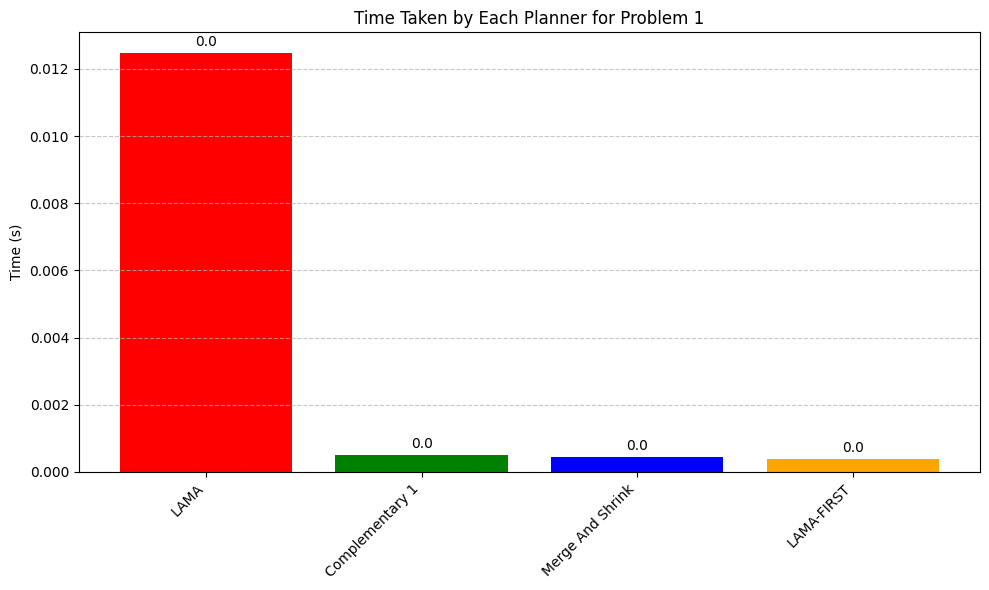

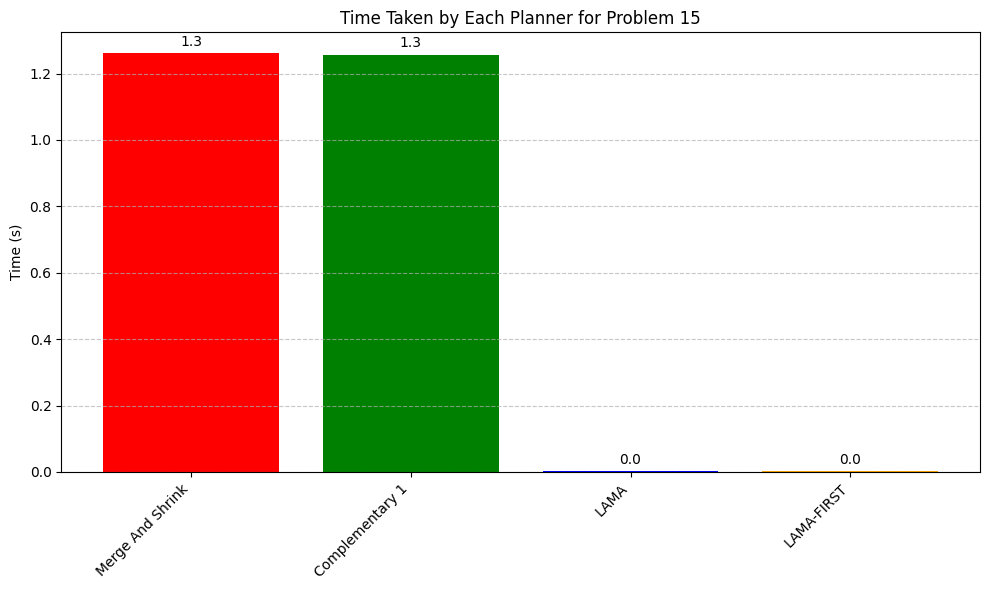

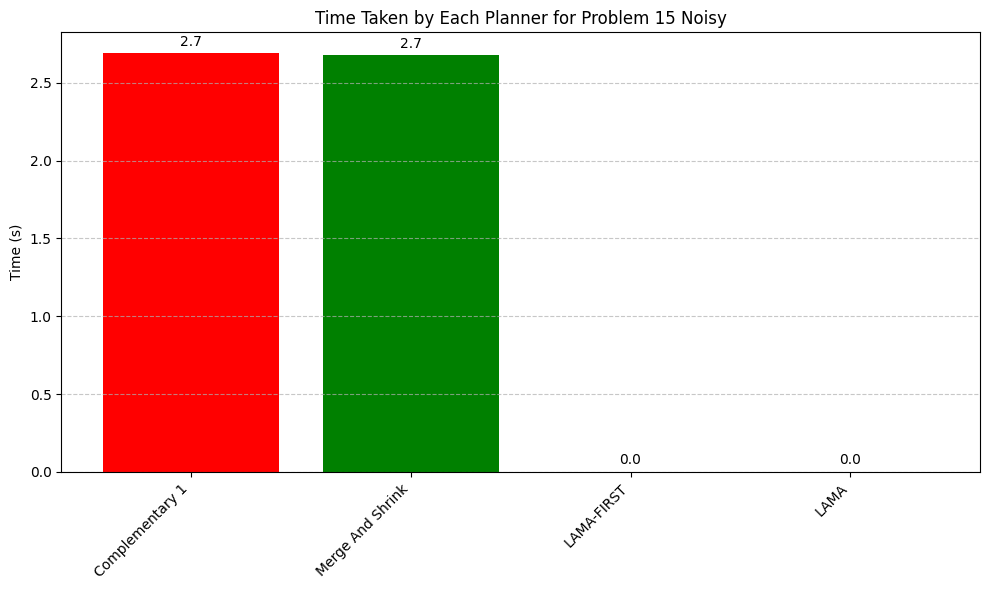

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_trace_alignment_times(planners, trace_alignment_times, problem_name):
    # Create DataFrame
    data = {'Planner': planners, 'Time (s)': trace_alignment_times}
    df = pd.DataFrame(data)
    df_sorted = df.sort_values(by='Time (s)', ascending=False)

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot bars with different colors
    bars = ax.bar(df_sorted['Planner'], df_sorted['Time (s)'], color=['red', 'green', 'blue', 'orange'])

    # Add labels and title
    ax.set_ylabel('Time (s)')
    ax.set_title(f'Time Taken by Each Planner for {problem_name}')

    # Add grid
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Add data labels
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
                    textcoords="offset points", ha='center', va='bottom')

    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels
    plt.tight_layout()  # Adjust layout to prevent clipping of labels
    plt.show()

# Example usage
planners = ['LAMA', 'LAMA-FIRST', 'Complementary 1', 'Merge And Shrink']

# Results for Problem A
trace_alignment_times_a = [0.0124637, 0.0003853758, 0.000495083, 0.000451542]

# Results for Problem B
trace_alignment_times_b = [ 0.00127013,0.00126429,1.25732,1.26117]


# Results for Problem C
trace_alignment_times_c = [ 0.00172012,0.00173988,2.69042,2.67828]


# Plot for each problem
plot_trace_alignment_times(planners, trace_alignment_times_a, "Problem 1")
plot_trace_alignment_times(planners, trace_alignment_times_b, "Problem 15")
plot_trace_alignment_times(planners, trace_alignment_times_c, "Problem 15 Noisy")

